In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import scipy.io as sio
from dataclasses import dataclass
from typing import List, Tuple
import os
from dotenv import load_dotenv
load_dotenv()
import tidy3d as td
from tidy3d import web
import numpy as np
from pathlib import Path
from stl import mesh
import matplotlib.pyplot as plt

In [2]:
import sys
import os

# Assuming /AutomationModule is in the root directory of your project
sys.path.append(os.path.abspath(fr'H:\phd stuff\tidy3d'))

from AutomationModule import * 

import AutomationModule as AM

In [3]:
def get_coords(multiplication_factor,t_slab_x,t_slab_y,t_slab_z):
    x_size,y_size,z_size = t_slab_x/multiplication_factor,t_slab_y/multiplication_factor,t_slab_z
    coordinates_slabs=[]
    for i in range(multiplication_factor):
        for j in range(multiplication_factor):
            center_x = (i - ( multiplication_factor/ 2) + 0.5) * x_size
            center_y = (j - ( multiplication_factor/ 2) + 0.5) * y_size
            center_z = 0  # All cubes are centered on the z=0 plane
            coord_item = {
                    "X": (center_x - x_size/2, center_x + x_size/2),
                    "Y": (center_y - y_size/2, center_y + y_size/2),
                    "Z": (-z_size/2, z_size/2),
                    "center": (center_x, center_y, center_z)
                    }
            
            coordinates_slabs+=[coord_item]

    return coordinates_slabs

In [4]:
# Function to create a solid cylinder with specified center coordinates
def create_cylinder_from_ends(top_center, bottom_center, radius):
    # Calculate height of the cylinder
    height = np.linalg.norm(np.array(top_center) - np.array(bottom_center))
    bottom_center=bottom_center

    # Calculate the vector direction of the cylinder
    axis_direction = np.array(top_center) - np.array(bottom_center)
    axis_direction /= np.linalg.norm(axis_direction) #Unitary vector to calculate rotation angle 

    # Calculate the rotation matrix to align cylinder with the given axis direction
    z_axis = np.array([0, 0, 1])
    rotation_axis = np.cross(z_axis, axis_direction)
    rotation_angle = np.arccos(np.dot(z_axis, axis_direction))
    rotation_matrix = mesh.Mesh.rotation_matrix(rotation_axis, rotation_angle)
    # Create a 4x4 identity matrix
    matrix_4x4 = np.eye(4)

    # Insert the 3x3 matrix into the top-left corner of the new matrix
    matrix_4x4[:3, :3] = np.copy(rotation_matrix)

    # Set the fourth column and fourth row for homogeneous transformation
    # The typical homogeneous transformation uses [0, 0, 0, 1] for the last row and column
    matrix_4x4[3, :3] = [0, 0, 0]  # Fourth row
    matrix_4x4[:3, 3] = [0, 0, 0]  # Fourth column
    matrix_4x4[3, 3] = 1           # Bottom-right corner remains 1

    
   
    cylinder_center = tuple((np.array(top_center) + np.array(bottom_center))/2)
    trans = td.Transformed.translation(cylinder_center[0],cylinder_center[1],cylinder_center[2])
    transformed = td.Transformed(geometry=td.Cylinder(center=(0,0,0), radius=radius, length=height),transform=trans@matrix_4x4)

    return transformed

In [5]:
tidy3dAPI = os.environ["API_TIDY3D_KEY"]

In [6]:
a = 3.4
run = False
lambdas = a/np.array([0.3,0.9]) 


In [7]:
folder_path = rf"H:\phd stuff\tidy3d\structures\08_13_2024 Luis H5 18.01a\sample 2"
project_name = "11_07_2024 Florescu LSU Focused Beam Ref 60ps"
postprocess_results = []
runtime_ps = 30e-12
min_steps_per_lambda = 20
for direction in ["z"]: 
    for filename in os.listdir(folder_path):
     for perm in [2.7**2]:
        print(filename)
        if not (Path(filename).suffix==".h5" or Path(filename).suffix==".stl"):
            continue 
        if os.path.isfile(os.path.join(folder_path, filename)):
            file=os.path.join(folder_path, filename)
            structure_1 = AM.loadAndRunStructure(key = tidy3dAPI, file_path=file
                                            ,direction=direction, lambda_range=lambdas,
                                            box_size=14.3,runtime_ps=runtime_ps,min_steps_per_lambda=min_steps_per_lambda, permittivity=perm,
                                           scaling=1,shuoff_condtion=1e-20, verbose=True, 
                                           monitors=["flux"], freqs=250, 
                                           cut_condition=1.0, source="planewave", absorbers=120, use_permittivity=False,
                                           ref_only=True
                                           )

02_Sample_600_res_L18.01_28ff_eps.h5
Configured successfully.


In [8]:
file_path =  fr"H:\phd stuff\tidy3d\structures\End2EndFiles\Florescu LSU 14.3\ak4_1000_ends.dat"
data = []
with open(file_path, 'r') as file:
    for line in file: 
        row = [float(value) for value in line.split()]
        data += [np.array(row)]

data = np.array(data)

tops_centered = (data[:,:3])
bottoms_centered = (data[:,3:])

radius = 0.38


cyl_group = []



coords = get_coords(structure_1.multiplication_factor,structure_1.t_slab_x,structure_1.t_slab_y,structure_1.t_slab_z)


for k,coord in enumerate(coords):
    tops = np.copy(tops_centered)
    bottoms = np.copy(bottoms_centered)
    for cil,item in enumerate(tops):
         cyl_group.append(create_cylinder_from_ends(tops[cil], bottoms[cil], radius))

    
   


In [9]:
sim = structure_1.sim


13:32:58 W. Europe Standard Time WARNING: Structure at 'structures[1]' has      
                                 bounds that extend exactly to simulation edges.
                                 This can cause unexpected behavior. If         
                                 intending to extend the structure to infinity  
                                 along one dimension, use td.inf as a size      
                                 variable instead to make this explicit.        

                                 WARNING: Suppressed 1 WARNING message.         

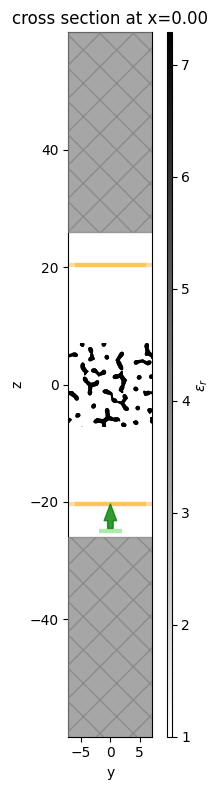

Time Steps = 150750
Grid Points = 9.666034999999999 million



In [10]:
Lz = structure_1.Lz+15
sim = sim.copy(update={"size":(structure_1.Lx,structure_1.Ly,Lz)})
structure_1.Lz = Lz


medium=td.Medium(permittivity=structure_1.permittivity_value)
eps_eff  = ((2+structure_1.permittivity_value )+ 2*0.3*(structure_1.permittivity_value-1))/((2+structure_1.permittivity_value)-0.3*(structure_1.permittivity_value-1))
eps_eff = 1
medium_eff=td.Medium(permittivity=eps_eff)
structure = td.Structure(geometry=td.GeometryGroup(geometries=cyl_group),  medium=medium)

slices = np.array([14.3])

add_ref = True
for cut in slices: 
  box_in = td.Box(center=[0, 0,-(structure_1.Lz/2+structure_1.t_slab_z/2)/2], size=[td.inf, td.inf, structure_1.Lz / 2-structure_1.t_slab_z/2])
  box_out = td.Box(center=[0, 0,(structure_1.Lz/2+structure_1.t_slab_z/2)/2], size=[td.inf, td.inf, structure_1.Lz / 2-structure_1.t_slab_z/2 ])
  struct_in = td.Structure(geometry=box_in, medium=medium_eff)
  struct_out = td.Structure(geometry=box_out, medium=medium_eff)

  
  cube_eff = td.Structure(geometry= td.Box(
                        center=(0, 0 ,cut/2),
                        size=(
                                structure_1.t_slab_x if structure_1.direction == "x"  else td.inf, 
                                structure_1.t_slab_y if structure_1.direction == "y"  else td.inf, 
                                structure_1.t_slab_z-cut if structure_1.direction == "z"  else td.inf
                              ),
                    ),medium=medium_eff)
  
  #Source###################################################
  source = td.PlaneWave(
      source_time = td.GaussianPulse(
          freq0=structure_1.freq0,
          fwidth=structure_1.freqw
      ),
      size= (4,4,0),
      # size= (td.inf,td.inf,0),
      center=(0,0,-(structure_1.Lz)/2 +1),
      direction='+',
      name='planewave',
      )

  ##########################################################


  ##Monitor Field####
  time_monitorFieldLateral = td.FieldTimeMonitor(
                center = (0,0,0),
                size = (0,structure_1.Ly,structure_1.Lz),
                    start=0,
                    stop=structure_1.t_stop,
                    interval=200,
                    fields=["Ex", "Ey", "Ez"],
                    name="time_monitorFieldLateral",
                )


#########################################################


#Monitor Flux#################

  monitor_1 = td.FluxMonitor(
                center = (
                            (structure_1.Lx - structure_1.spacing)*0.5 if structure_1.direction == "x" else 0, 
                            (structure_1.Ly - structure_1.spacing)*0.5 if structure_1.direction == "y" else 0, 
                            (structure_1.Lz - structure_1.spacing)*0.5 if structure_1.direction == "z" else 0
                            ),
                size = (
                    0 if structure_1.direction == "x" else td.inf, 
                    0 if structure_1.direction == "y" else td.inf, 
                    0 if structure_1.direction == "z" else td.inf, 
                    ),
                freqs = structure_1.monitor_freqs,
                name='flux1' #To the right 
            )
  

  monitor_2 = td.FluxMonitor(
                center = (
                        (-structure_1.Lx+structure_1.spacing)*0.5 if structure_1.direction =="x" else 0, 
                        (-structure_1.Ly+structure_1.spacing)*0.5 if structure_1.direction =="y" else 0, 
                        (-structure_1.Lz+structure_1.spacing)*0.5 if structure_1.direction =="z" else 0
                        ),
                size = (
                    0 if structure_1.direction == "x" else td.inf, 
                    0 if structure_1.direction == "y" else td.inf, 
                    0 if structure_1.direction == "z" else td.inf
                    ),
                freqs = structure_1.monitor_freqs,
                name='flux2'#To the left
            )
  

  monitor_1_small = td.FluxMonitor(
                center = (
                            (structure_1.Lx - structure_1.spacing)*0.5 if structure_1.direction == "x" else 0, 
                            (structure_1.Ly - structure_1.spacing)*0.5 if structure_1.direction == "y" else 0, 
                            (structure_1.Lz - structure_1.spacing)*0.5 if structure_1.direction == "z" else 0
                            ),
                size = (
                    0 if structure_1.direction == "x" else 12, 
                    0 if structure_1.direction == "y" else 12, 
                    0 if structure_1.direction == "z" else 12, 
                    ),
                freqs = structure_1.monitor_freqs,
                name='flux1_small' #To the right 
            )


  monitor_2_small = td.FluxMonitor(
                center = (
                        (-structure_1.Lx+structure_1.spacing)*0.5 if structure_1.direction =="x" else 0, 
                        (-structure_1.Ly+structure_1.spacing)*0.5 if structure_1.direction =="y" else 0, 
                        (-structure_1.Lz+structure_1.spacing)*0.5 if structure_1.direction =="z" else 0
                        ),
                size = (
                    0 if structure_1.direction == "x" else 12, 
                    0 if structure_1.direction == "y" else 12, 
                    0 if structure_1.direction == "z" else 12
                    ),
                freqs = structure_1.monitor_freqs,
                name='flux2_small'#To the left

  )

  far_field_monitor = td.FieldProjectionAngleMonitor(
                center = (
                            (structure_1.Lx - structure_1.spacing)*0.5 if structure_1.direction == "x" else 0, 
                            (structure_1.Ly - structure_1.spacing)*0.5 if structure_1.direction == "y" else 0, 
                            (structure_1.Lz - structure_1.spacing)*0.5 if structure_1.direction == "z" else 0
                            ),
                size = (
                    0 if structure_1.direction == "x" else td.inf, 
                    0 if structure_1.direction == "y" else td.inf, 
                    0 if structure_1.direction == "z" else td.inf, 
                    ),
                  phi=[0, np.pi/2],
                  theta=np.linspace(-np.pi/2, np.pi/2, 100),
                far_field_approx=True,
                freqs = structure_1.monitor_freqs,
                name='far_field' #To the right 
            )


##############################################


  if structure_1.t_slab_z-cut==0:
    sim = sim.copy(update={"structures":[structure,struct_in, struct_out],"monitors":[monitor_1,monitor_2,monitor_1_small,monitor_2_small],"sources":[source]})
  else:
    sim = sim.copy(update={"structures":[structure,struct_in, struct_out,cube_eff],"monitors":[monitor_1,monitor_2,monitor_1_small,monitor_2_small],"sources":[source]})
  sim_name = f"Focused Beam LSU perm {perm} runtime {runtime_ps}ps nu {(a/lambdas[0]):.3g} - {(a/lambdas[1]):.3g} Size - {cut:.3g}"
#   print(sim_name)
  sim.plot_3d()
  fig, ax = plt.subplots(1, tight_layout=True, figsize=(16, 8))
  freqs_plot = (structure_1.freq_range[0], structure_1.freq_range[1])
  sim.plot_eps(x=0, freq=freqs_plot[0], ax=ax)
  plt.show()
  print(f"Time Steps = {sim.num_time_steps}\n"
        f"Grid Points = {sim.num_cells*1e-6} million\n")  
  if run:
        if add_ref:
            print("running ref...")
            id0 = web.upload(sim.copy(update={"structures":[],"medium":medium_eff,"run_time":60e-12}), folder_name=project_name,task_name=sim_name+'_0', verbose=True)
            web.start(task_id = id0)
            web.monitor(task_id=id0,verbose=True)
            add_ref=False

        id =web.upload(sim, folder_name=project_name,task_name=sim_name, verbose=True)
        web.start(task_id = id)
        web.monitor(task_id=id,verbose=True)
    
        ids = (id0 if id0 else '') +'\n' + id
        incidence_folder = "z_incidence"
        file_path = rf"H:\phd stuff\tidy3d\data/{project_name}/{incidence_folder}/{sim_name}.txt"
        # Check if the folder exists
        if not os.path.exists( rf"H:\phd stuff\tidy3d\data/{project_name}/{incidence_folder}"):
            os.makedirs(rf"H:\phd stuff\tidy3d\data/{project_name}/{incidence_folder}")
            print(f"Folder '{project_name}/{incidence_folder}' created successfully.")

        # Open file in write mode
        with open(file_path, "w") as file:
            # Write the string to the file
            file.write(ids)



